### 1. Preprocessing and loading datasets
Firstly, tensorflow and pandas are imported for data preprocessing. Ids are dropped since they are irrelevant features.

In [1]:
import tensorflow as tf
import pandas as pd

train_set = pd.read_csv('./data/train-1.csv')
train_set = train_set.drop(['Id'],axis=1)

In [2]:
print(train_set.head(10)) #printing first 10 rows

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   
5          50       RL         85.0    14115   Pave   NaN      IR1   
6          20       RL         75.0    10084   Pave   NaN      Reg   
7          60       RL          NaN    10382   Pave   NaN      IR1   
8          50       RM         51.0     6120   Pave   NaN      Reg   
9         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
0         Lvl    AllPub    Inside    ...            0    NaN    NaN   
1         Lvl    AllPub       FR2    ...            0    NaN    NaN   
2         Lvl   

In [3]:
description = train_set.describe(include = 'all')
corr = train_set.corr()

In [4]:
print(description)

         MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1460.000000     1460  1201.000000    1460.000000   1460    91   
unique          NaN        5          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN     1151          NaN            NaN   1454    50   
mean      56.897260      NaN    70.049958   10516.828082    NaN   NaN   
std       42.300571      NaN    24.284752    9981.264932    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7553.500000    NaN   NaN   
50%       50.000000      NaN    69.000000    9478.500000    NaN   NaN   
75%       70.000000      NaN    80.000000   11601.500000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig      ...           PoolArea  \
count      1460        1460      1460      1

As you can see above in description of data, many features have missing values (ones with count less than 1460)

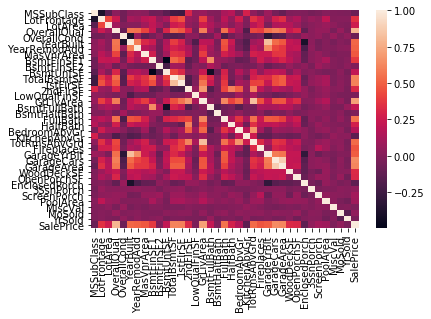

In [5]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns
    )

Heatmap shows that there are some strong correlations between some of the features as marked by white colors.

### 2. Creating model
After preprocessing the data, feature columns are constructed for estimator class in tensorflow.

In [6]:
from math import isnan
numeric_keys = []
categorical_keys = []
date_keys = []
for column in train_set.columns:
    #if a column has less than 100 entries, it is dropped because it contains too few values to be relevant
    if description.loc["count"][column] < 100:
        train_set = train_set.drop([column],axis=1)
    #categorize columns to date columns
    elif ("Yr" in column) or ("Year" in column):
        train_set[column] = train_set[column].fillna(description.loc["mean"][column])
        date_keys.append(column)
    #categorical columns are categorized
    elif isnan(description.loc["mean"][column]):
        train_set[column] = train_set[column].fillna(description.loc["top"][column])
        categorical_keys.append(column)
    #otherwise they are numerical columns
    else:
        train_set[column] = train_set[column].fillna(description.loc["mean"][column])
        numeric_keys.append(column)
#Since SalePrice is a label, it's removed from numerical column
numeric_keys.remove('SalePrice')

In order to process the features, each feature was first cateogrized into either numeric, categorical, or date columns. Missing values in numeric values were filled with the mean from the description object and missing values in categorical values were filled with most frequently found category. Any column containing Yr and Year where categorized to a date column.

In [7]:
from sklearn.model_selection import train_test_split
labels = train_set.pop('SalePrice')
features = train_set
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size=0.2)
variance = y_test.var()
train_input_fn = tf.estimator.inputs.pandas_input_fn(X_train,y_train,shuffle=True,num_epochs=5000,batch_size=128)
eval_input_fn = tf.estimator.inputs.pandas_input_fn(X_test,y_test,shuffle=True)

The features and labels are then divided into train and validation set and are fed into train_input_fn and eval_input_fn for estimator class

In [8]:
feature_column = []
for key in categorical_keys:
    #embedding columns are created for categorical values
    feature = tf.feature_column.categorical_column_with_hash_bucket(key,description.loc["unique"][key])
    feature = tf.feature_column.embedding_column(feature,dimension=4)
    feature_column.append(feature)
for key in numeric_keys:
    #numerical columns are made
    feature = tf.feature_column.numeric_column(key,dtype=tf.float64)
    feature_column.append(feature)
for key in date_keys:
    #date columns were bucketized to be treated as a categorical data and they were divided based on their distribution
    original = tf.feature_column.numeric_column(key)
    feature = tf.feature_column.bucketized_column(original,[description.loc["25%"][key],description.loc["50%"][key],description.loc["75%"][key]])
    feature = tf.feature_column.indicator_column(feature)
    feature_column.append(feature)

Basic feature columns were made by bucketizing date columns into cateogrical columns and cateogrical columns were transferred into embedding columns.

In [9]:
def create_crossed_column(c1,c2,c1_boundary,c2_boundary):
    c1_bucketized_column = tf.feature_column.bucketized_column(tf.feature_column.numeric_column(c1),c1_boundary)
    c2_bucketized_column = tf.feature_column.bucketized_column(tf.feature_column.numeric_column(c2),c2_boundary)
    return tf.feature_column.embedding_column(
                tf.feature_column.crossed_column([c1_bucketized_column,c2_bucketized_column],20),
                dimension=4
            )

feature_column.append(create_crossed_column('TotRmsAbvGrd','GrLivArea',[5,6,7],[500,1130,1464,1776,2500]))
feature_column.append(create_crossed_column('1stFlrSF','TotalBsmtSF',[882,1087,1391,1700],[330,795,991,1298,1700]))
feature_column.append(create_crossed_column('GarageArea','GarageCars',[1,2,3],[334,480,576]))

Based on the correlation heatmap above, crossed feature columns were made if they had a correlation above 0.80. Since these data are numerical they were first bucketized into cateogrical then transferred crossed column. Selection of bucket boundary was based on data distribution of the numerical data. (each boundary is approx. 1 std away from each other)

### Rationale for hyperparameters
Learning rate of 0.01 was chosen after by-hand hyperparameter tuning.
Hidden units were not as exessively added like titanic model, however, more units and layers can be added for better performance.
Batch normalization was applied for faster learning.
Dropout was set to 0.75 for preventing overfitting and was chosen after by-hand hyperparmeter tuning.

In [10]:
run_config = tf.estimator.RunConfig(
        save_checkpoints_steps=500,
        save_summary_steps=500,
        model_dir="./model/",
        keep_checkpoint_max=None
)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
estimator = tf.estimator.DNNRegressor(
        feature_columns=feature_column,
        hidden_units=[100,120,120,100],
        optimizer=optimizer,
        dropout=0.75,
        batch_norm=True,
        config=run_config
)

INFO:tensorflow:Using config: {'_model_dir': './model/', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': None, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B0AE898780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Now, it's ready to run!

In [11]:
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn,max_steps=20000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn,throttle_secs=40,start_delay_secs=40)
tf.estimator.train_and_evaluate(estimator,train_spec,eval_spec,)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 500 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:loss = 4092799500000.0, step = 0
INFO:tensorflow:global_step/sec: 5.98029
INFO:tensorflow:loss = 5699203000000.0, step = 100 (16.723 sec)
INFO:tensorflow:global_step/sec: 11.7952
INFO:tensorflow:loss = 5138940000000.0, step = 200 (8.477 sec)
INFO:tensorflow:global_step/sec: 11.4156
INFO:tens

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-06-04:46:54
INFO:tensorflow:Saving dict for global step 3000: average_loss = 11457695000.0, global_step = 3000, label/mean = 186239.39, loss = 1115215600000.0, prediction/mean = 108014.68
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3000: ./model/model.ckpt-3000
INFO:tensorflow:global_step/sec: 6.06162
INFO:tensorflow:loss = 529433030000.0, step = 3000 (16.497 sec)
INFO:tensorflow:global_step/sec: 9.72772
INFO:tensorflow:loss = 465815670000.0, step = 3100 (10.281 sec)
INFO:tensorflow:global_step/sec: 8.73994
INFO:tensorflow:loss = 1028122740000.0, step = 3200 (11.556 sec)
INFO:tensorflow:global_step/sec: 10.1625
INFO:tensorflow:loss = 519428900000.0, step = 3300 (9.724 sec)
INFO:tensorflow:global_step/sec: 10.652
INFO:tensorflow:loss = 1161626300000.0, step = 3400 (9.388 sec)
INFO:tensorflow:Saving checkpoints for 3500 into ./model/model.

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6000: ./model/model.ckpt-6000
INFO:tensorflow:global_step/sec: 5.90831
INFO:tensorflow:loss = 369439280000.0, step = 6000 (16.925 sec)
INFO:tensorflow:global_step/sec: 10.9723
INFO:tensorflow:loss = 537364700000.0, step = 6100 (9.114 sec)
INFO:tensorflow:global_step/sec: 10.7699
INFO:tensorflow:loss = 490146230000.0, step = 6200 (9.285 sec)
INFO:tensorflow:global_step/sec: 10.2249
INFO:tensorflow:loss = 496679260000.0, step = 6300 (9.780 sec)
INFO:tensorflow:global_step/sec: 9.43236
INFO:tensorflow:loss = 673534000000.0, step = 6400 (10.606 sec)
INFO:tensorflow:Saving checkpoints for 6500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-6500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-04:53:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./mod

INFO:tensorflow:global_step/sec: 10.1467
INFO:tensorflow:loss = 524299340000.0, step = 9100 (9.855 sec)
INFO:tensorflow:global_step/sec: 8.20009
INFO:tensorflow:loss = 371791760000.0, step = 9200 (12.195 sec)
INFO:tensorflow:global_step/sec: 10.7077
INFO:tensorflow:loss = 502371250000.0, step = 9300 (9.339 sec)
INFO:tensorflow:global_step/sec: 10.537
INFO:tensorflow:loss = 414403070000.0, step = 9400 (9.490 sec)
INFO:tensorflow:Saving checkpoints for 9500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-9500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-04:59:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-9500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-06-04:59:07
INFO:tensorflow:Saving dict for global s

INFO:tensorflow:loss = 378766820000.0, step = 12200 (10.824 sec)
INFO:tensorflow:global_step/sec: 9.33962
INFO:tensorflow:loss = 445070380000.0, step = 12300 (10.706 sec)
INFO:tensorflow:global_step/sec: 10.5637
INFO:tensorflow:loss = 365133100000.0, step = 12400 (9.467 sec)
INFO:tensorflow:Saving checkpoints for 12500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-12500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-05:05:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-12500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-06-05:05:09
INFO:tensorflow:Saving dict for global step 12500: average_loss = 3634391300.0, global_step = 12500, label/mean = 186239.39, loss = 353747440000.0, prediction/mean = 183884.38
I

INFO:tensorflow:global_step/sec: 10.6172
INFO:tensorflow:loss = 359641500000.0, step = 15400 (9.418 sec)
INFO:tensorflow:Saving checkpoints for 15500 into ./model/model.ckpt.
INFO:tensorflow:./model/model.ckpt-15500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-05:10:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-15500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-06-05:10:49
INFO:tensorflow:Saving dict for global step 15500: average_loss = 5141323000.0, global_step = 15500, label/mean = 186239.4, loss = 500422100000.0, prediction/mean = 177590.45
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15500: ./model/model.ckpt-15500
INFO:tensorflow:global_step/sec: 6.16668
INFO:tensorflow:loss = 314650900000

INFO:tensorflow:./model/model.ckpt-18500 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-05:15:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-18500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-06-05:15:59
INFO:tensorflow:Saving dict for global step 18500: average_loss = 5197886000.0, global_step = 18500, label/mean = 186239.39, loss = 505927570000.0, prediction/mean = 188952.72
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18500: ./model/model.ckpt-18500
INFO:tensorflow:global_step/sec: 6.70462
INFO:tensorflow:loss = 331098100000.0, step = 18500 (14.915 sec)
INFO:tensorflow:global_step/sec: 11.8984
INFO:tensorflow:loss = 510541330000.0, step = 18600 (8.405 sec)
INFO:tensorflow:global_step/sec: 11.607

({'average_loss': 5041114000.0,
  'label/mean': 186239.4,
  'loss': 490668430000.0,
  'prediction/mean': 169162.45,
  'global_step': 20000},
 [])

### Training results
Final loss: 4.90e+11

In [14]:
loss = 490668430000.0
#pandas take n-1 normalized variance so (y_test.shape[0]-1) is used to cancel it out.
variance = (y_test.shape[0]-1) * y_test.var()
r2_score = 1-(loss/variance)
print("r2_score result: ",r2_score)

r2_score result:  0.7988879790915022


r2_score result was calculated based on the variance of the y_test set and loss.
The result yields around 0.8 correlation score. A good indication of accuracy of the model but can be improved by adding more layers to the network since it only contains 4 layers for now.

#### Loss graph

![](https://github.com/RE-N-Y/ml-playground/raw/master/graphs/graph3.PNG)